In [1]:
# This notebook replicates McGill-van Ryzin 2000 Management Science Article

In [160]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

In [3]:
# Test problem scenarios: four classes with different fares and demand statistics
n_class = 4
fare = np.array([1050, 567, 527, 350])
mean = np.array([17.3, 45.1, 73.6, 19.8])
std = np.array([5.8, 15.0, 17.4, 6.6])

In [4]:
mean_cumsum = np.cumsum(mean)
std_cumsum = np.sqrt(np.cumsum(std**2))
totalrev = fare * mean
totalrev_cumsum = np.cumsum(totalrev)

In [5]:
(mean_cumsum, std_cumsum, totalrev, totalrev_cumsum)

(array([ 17.3,  62.4, 136. , 155.8]),
 array([ 5.8       , 16.08228839, 23.69388107, 24.59593462]),
 array([18165. , 25571.7, 38787.2,  6930. ]),
 array([18165. , 43736.7, 82523.9, 89453.9]))

In [6]:
# Compute weighted average revenue
avgrev_weighted = totalrev_cumsum / mean_cumsum
# Probability of demand being higher than the protection level
prob_emsr = np.array([fare[i+1] / avgrev_weighted[i] for i in range(n_class - 1)])

In [7]:
avgrev_weighted, prob_emsr

(array([1050.        ,  700.90865385,  606.79338235,  574.15853659]),
 array([0.54      , 0.75188114, 0.5768026 ]))

In [8]:
# EMSR-b protection levels
theta_emsr = st.norm.ppf(1 - prob_emsr, mean_cumsum[:-1], std_cumsum[:-1])

In [9]:
theta_emsr

array([ 16.71748442,  51.4572678 , 131.41001141])

In [10]:
# Calculate optimal protection level based on stochastic approximation (SA)
ratio = np.array([fare[i] / fare[0] for i in range(1, n_class)])

In [95]:
# In order to find optimal protection levels for SA algorithm, we use
# monte carlo integration specified in McGill-van Ryzin(2004) book
# Page 43
size = 10000
# Normal dist
# demand = np.array([[np.random.normal(mean[i], std[i], 1) for i in range(n_class)] for _ in range(size)])
# demand = demand.reshape(size, n_class)
demand = np.array([np.random.normal(mean[i], std[i], size) for i in range(n_class)])

# Lognormal dist
# Be careful when calculating parameters: https://en.wikipedia.org/wiki/Log-normal_distribution
# logmean = np.log(mean**2 / np.sqrt(mean**2 + std**2))
# logstd = np.sqrt(np.log(1 + std**2 / mean**2))
# demand = np.array([np.random.lognormal(logmean[i], logstd[i], size=size) for i in range(n_class)])

demand = np.transpose(demand)

In [96]:
demand.shape

(10000, 4)

In [97]:
demand[:10,]

array([[21.62486863, 27.92748391, 84.97127776, 16.99846853],
       [19.3631103 , 49.87434851, 78.81036029, 20.43587187],
       [17.31127482,  4.63230063, 89.11084014, 17.62894622],
       [ 9.30074943, 60.83916584, 85.03330088, 18.58848907],
       [20.09015542, 36.33417251, 74.07265712, 12.11725325],
       [14.42728519, 38.64379411, 56.31701152, 21.00365917],
       [11.04649668, 54.58613334, 67.43894104, 21.79743287],
       [ 7.7713872 , 54.47043025, 49.22245008, 25.76961862],
       [10.64942454, 53.74086091, 34.84584707, 20.94979436],
       [21.27177994, 24.48224663, 67.85039387, 28.82718699]])

In [98]:
# Compute random demand partial sums
demand_cumsum = np.array([np.cumsum(demand[i]) for i in range(size)])
demand_cumsum[:10]

array([[ 21.62486863,  49.55235254, 134.5236303 , 151.52209883],
       [ 19.3631103 ,  69.23745881, 148.0478191 , 168.48369097],
       [ 17.31127482,  21.94357545, 111.05441559, 128.68336181],
       [  9.30074943,  70.13991526, 155.17321614, 173.76170521],
       [ 20.09015542,  56.42432793, 130.49698505, 142.6142383 ],
       [ 14.42728519,  53.0710793 , 109.38809082, 130.39174999],
       [ 11.04649668,  65.63263002, 133.07157106, 154.86900393],
       [  7.7713872 ,  62.24181745, 111.46426753, 137.23388614],
       [ 10.64942454,  64.39028545,  99.23613252, 120.18592688],
       [ 21.27177994,  45.75402657, 113.60442043, 142.43160743]])

In [99]:
theta_norm = []
cumsum_copy = demand_cumsum.copy()
for j in range(n_class - 1):
    # Step 1
    cumsum_copy_ordered = np.sort(cumsum_copy[:, j])
    # Step 2
    threshold = int(np.floor((fare[j+1] / fare[j]) * len(cumsum_copy_ordered)))
    # An error in the initial algorithm. After calculation l*, there should be
    # one more calculation before finding y_j, which is the index used to calculate
    # y_j should be |k|-l*, not l* itself.
    threshold = len(cumsum_copy_ordered) - threshold
    theta = 0.5 * (cumsum_copy_ordered[threshold-1] + cumsum_copy_ordered[threshold])
    # Step 3
    index = np.where(cumsum_copy[:, j] > theta)
    # In step 3, we only keep the updated values we use for next iteration
    cumsum_copy = cumsum_copy[index]
    theta_norm.append(theta)

In [100]:
theta_norm = np.array(theta_norm)
theta_norm

array([ 16.82599064,  44.64558198, 133.13734128])

In [101]:
# Algorithm starting protection levels
theta_low = np.array([0, 15, 65])
theta_high = np.array([35, 110, 210])
expected_demand = np.sum(mean)
cap_low = 124
cap_high = 164

# For SA algorithm, we have two parameters for step size: param1 and param2
param1, param2 = 200, 10

# Calculate load factors
load_high = expected_demand / cap_low
load_low = expected_demand / cap_high
print("%.2f" % load_high, "%.2f" % load_low)

1.26 0.95


In [42]:
obs_demand_test = np.array([np.random.normal(mean[i], std[i], 1) for i in range(n_class)])
obs_demand_test, theta_low, fare

(array([[19.4734368 ],
        [50.61133193],
        [64.70523267],
        [ 7.47078705]]),
 array([ 0, 15, 65]),
 array([1050,  567,  527,  350]))

In [138]:
sold_sa = []
obs_demand = np.array([18, 58, 86, 14])
capacity_sa = cap_low
theta_update = theta_low
for i in range(n_class - 1, 0, -1):
    # Tickets sold with stochastic approximation algorithm
    BL_sa = max(capacity_sa - theta_update[i-1], 0)
    sold1 = min(obs_demand[i], BL_sa)
    print(sold1)
    sold_sa.append(sold1)
    print(sold_sa)
    capacity_sa = capacity_sa - sold1
# Calculate revenue from first class separately since there is no booking limit
# for this class
sold_first_class = min(obs_demand[0], capacity_sa)
sold_sa.append(sold_first_class)
sold_sa = sold_sa[::-1]

14
[14]
86
[14, 86]
24
[14, 86, 24]


In [164]:
# For the remainder of the simulation, assume normal distribution
flights = 100
n_simulation = 100
thetas = []
revs_sa = []
revs_opt = []
for _ in range(n_simulation):
    # Start with initial protection levels for each simulation
    # change theta_low to theta_high for initial high protection levels
    theta_update = theta_high
    # Change cap_low to cap_high for low demand factor scenario
    capacity = cap_low
    for flight in range(flights):
        # Assume demand has normal distribution
        obs_demand = [np.random.normal(mean[i], std[i], 1) for i in range(n_class)]
        obs_demand = np.array(obs_demand).reshape(n_class,)
        # For each flight, tickets sold are calculated from scratch
        # For each flight, capacity is also traced back to original capacity
        # Calculate revenue, assuming low class arrives before high class
        sold_sa = []
        sold_opt = []
        capacity_sa = capacity
        capacity_opt = capacity
        # Assume low class arrives before high class
        for i in range(n_class - 1, 0, -1):
            # Tickets sold with stochastic approximation algorithm
            # It is possible that hypothetical protection level for a class exceeds capacity
            BL_sa = max(capacity_sa - theta_update[i-1], 0)
            # Tickets sold is the lower of booking requests and booking limits for that class
            sold1 = min(obs_demand[i], BL_sa)
            sold_sa.append(sold1)
            # Update capacity for the next arrival class
            capacity_sa = capacity_sa - sold1
            
            # Tickets sold with optimal protection levels
            BL_opt = max(capacity_opt - theta_norm[i-1], 0)
            sold2 = min(obs_demand[i], BL_opt)
            sold_opt.append(sold2)
            capacity_opt = capacity_opt - sold2
        # Calculate revenue from first class separately since there is no booking limit
        # for this class
        # SA algorithm
        sold_first_class_sa = min(obs_demand[0], capacity_sa)
        sold_sa.append(sold_first_class_sa)
        
        # Optimal protection levels
        sold_first_class_opt = min(obs_demand[0], capacity_opt)
        sold_opt.append(sold_first_class_opt)
        
        # Reverse the order since current array is from class 4 to class 1
        sold_sa = sold_sa[::-1]
        sold_opt = sold_opt[::-1]

        # Compute revenue
        rev_sa = np.inner(sold_sa, fare)
        rev_opt = np.inner(sold_opt, fare)
        # Store the revenue info
        revs_sa.append(rev_sa)
        revs_opt.append(rev_opt)
        
        obs_demand_cumsum = np.cumsum(obs_demand)
        
        # Compute if the demand for a class exceeds its corresponding protection levels 
        Y = np.array([1 if obs_demand_cumsum[i] > theta_update[i] else 0 for i in range(n_class - 1)])
        # Implement Equation(2) in vanRyzin-McGill 2000
        Z = np.cumprod(Y)
        # Calculate H(theta, x)
        H = ratio - Z
        theta_update = theta_update - (param1 / (param2+flight)) * H
        # Capacity constraint and nonnegativity for protection levels
        theta_update = np.minimum(theta_update, np.repeat(capacity, n_class - 1))
        theta_update = np.maximum(theta_update, np.zeros(n_class - 1))
        # Store protection levels evolvement
        thetas.append(theta_update)

thetas = np.array(thetas).reshape(n_simulation, flights, n_class - 1)
revs_sa = np.array(revs_sa).reshape(n_simulation, flights)
revs_opt = np.array(revs_opt).reshape(n_simulation, flights)

In [165]:
# Calculate averages for each flight over all simulations
thetas_avg = np.mean(thetas, axis = 0)
revs_sa_avg = np.mean(revs_sa, axis = 0)
revs_opt_avg = np.mean(revs_opt, axis = 0)

# Calculate revenue gap as percentages of revenue obtained from optimal protection levels
rev_gap = revs_sa_avg / revs_opt_avg

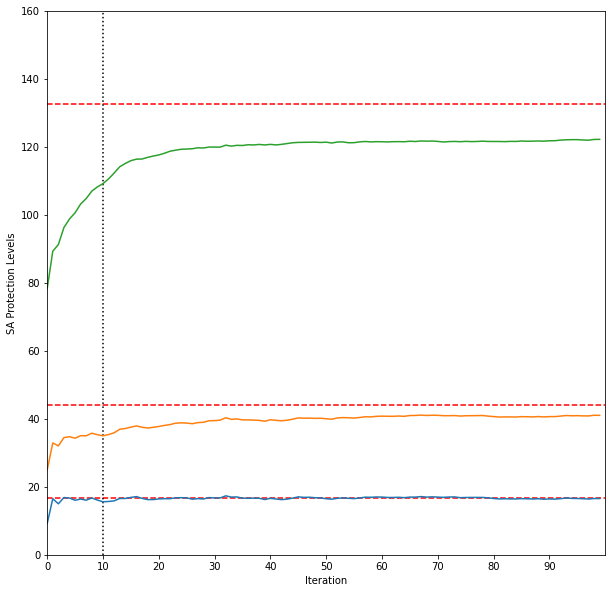

In [39]:
plt.figure(figsize=(10, 10))
plt.plot(thetas_avg)
plt.hlines(theta_norm, xmin = 0, xmax = 100, ls='dashed', color='r')
plt.axis([0, 100, 0, 160])
plt.xlabel('Iteration')
plt.ylabel('SA Protection Levels')
plt.xticks(np.arange(0, 100, step=10))
plt.vlines(10, ymin=0, ymax=160, ls='dotted')
plt.show()

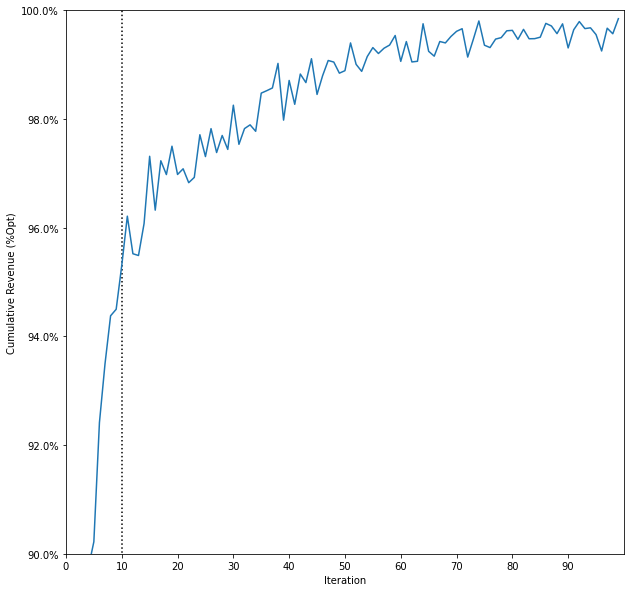

In [167]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.plot(rev_gap)
plt.axis([0, 100, 0.9, 1.0])
plt.xlabel('Iteration')
plt.ylabel('Cumulative Revenue (%Opt)')
plt.xticks(np.arange(0, 100, step=10))
plt.yticks(np.arange(0.9, 1.01, step=0.02))
ax.yaxis.set_major_formatter(PercentFormatter(1))
plt.vlines(10, ymin=0, ymax=1, ls='dotted')
plt.show()